# Experiments with textual misinformation detection using machine learning models
In this experiment, we train and test machine learning models for detecting misinformation based purely on the text. We evaluated the performance of 5 classification models with wide use in text classification problems.

**Models:**
* Logistic regression
* Bernoulli Naive-Bayes
* Multinomial Naive-Bayes
* Linear SVM
* KNN
* Random forest
* Gradient Boosting
* Multilayer Perceptron

# NOTES TO MYSELF

**To do:**
* max_features = 500
* linguistic features
* hyperparamater tunning; validation

**References:**
* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training


In [36]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
import pandas as pd
import numpy as np
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

start_time = time.time()

## Experiments
1. **ml-bow**<br> 
One of the best so far. Best F1: 0.6429 random forest<br>

* **ml-tfidf** <br>
Comparable with ml-bow. Best F1: 0.6278 random forest<br>

* **ml-tfidf-processed**<br>
Comparable with ml-bow and ml-tfidf. The pre-processing didn't had great impact. Precision slightly better.
Best F1: 0.6184 random forest<br>

* **ml-bow-processed**<br>
Same as ml-tfidf-processed. Best F1: 0.6254 random forest  <br>

* **ml-tfidf-smote**<br>
Good result. Smote improves F1 when using tf-idf. Best F1: 0.6426 random forest<br>

* **ml-tfidf-undersampling** <br>
Very poor approach. Undersampling is a bad ideia. Increases recall but greatly reduces accuracy. Best F1: 0.3570 bernoulli naive-bayes<br>

* **ml-tfidf-processed-smote**<br>
Good result. Best F1: 0.6470 random forest <br>

* **ml-bow-processed-smote**<br>
Poor. Smote does not goes well with bow. Best F1: 0.4037 bernoulli naive-bayes<br>

* **ml-bow-random_oversampling**<br>
~~Holy shit!!! This approuch overcame all the expectations! Best F1: 0.9658 random forest~~<br>
*Edit:* well, when things look too good to be true, they probably are. The good results were just a case of data leaking.

* **ml-tfidf-random_oversampling**<br>
Similar to *ml-bow-random_oversampling*

* **ml-bow-processed-random_oversampling**<br>
Similar to *ml-bow-random_oversampling*

* **ml-tfidf-processed-random_oversampling**<br>
Similar to *ml-bow-random_oversampling*

* **ml-bow-processed-random_oversampling-max_features**<br>
Poor.

* **ml-tfidf-processed-random_oversampling-max_features**<br>
Poor.


### Conclusions:
* Smote is not the best oversampling technique for text, specially for BOW features
* Pre-processing the data didn't appear to have a great impact, despite the great reduction of dimentionality
* BOW features are comparably to TF-IDF features
* Random oversampling is a good oversampling technique
* Use a maximum number of features wasn't a good approach

In [38]:
# results analysis
path = 'results/2018/ml/'
df_best = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1 score', 'auc score','vocab'])
#iterates over files
experiment = []
for filename in os.listdir(path):
    experiment.append(str(filename).replace('.csv',''))
    file_path = path + filename
    #print(filename)
    df_temp = pd.read_csv(file_path)
    best_ix = df_temp['f1 score'].argmax()
    best = df_temp.iloc[best_ix]
    df_best = df_best.append(best)
df_best['experiment'] = experiment
cols = df_best.columns.tolist()
cols = cols[-2:] + cols[:-2]
df_best = df_best[cols]
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best = df_best.sort_values(by='f1 score',ascending=False)
df_best.style.background_gradient(cmap='Blues')

,vocab,experiment,model,accuracy,precision,recall,f1 score,auc score
11,69571,ml-bow-random_oversampling,random forest,0.984593,0.884615,0.534884,0.666667,0.947504
9,55276,ml-bow-processed-random_oversampling,random forest,0.984185,0.872910,0.527806,0.657845,0.944896
12,69571,ml-tfidf-random_oversampling,random forest,0.984593,0.916667,0.511628,0.656716,0.951963
13,55276,ml-tfidf-processed-random_oversampling,random forest,0.984185,0.905455,0.503539,0.647173,0.947730
8,55276,ml-tfidf-processed-smote,random forest,0.983224,0.821151,0.533873,0.647059,0.952748
2,69571,ml-bow,random forest,0.983894,0.889286,0.503539,0.642995,0.940001
14,69571,ml-tfidf-smote,random forest,0.982932,0.809524,0.532861,0.642683,0.954696
4,69571,ml-tfidf,random forest,0.983806,0.928713,0.474216,0.627845,0.933053
15,55276,ml-bow-processed,random forest,0.983428,0.896226,0.480283,0.625411,0.936091
1,55276,ml-tfidf-processed,random forest,0.983573,0.934560,0.462083,0.618403,0.940400


# Begin experiment

In [3]:
base = 2018
pre_processed = True
experiment = 'ml-tfidf-random_oversampling' #ml-bow-processed-random_oversampling-max_features
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv(filepath)
df.head(5)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
2,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0
3,-4391661641377612003,01/08/18,13:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,5,1,0,1,Boaaa,0
4,-4391661641377612003,09/08/18,14:46,55,BRASIL,BRA,13,São Paulo,2018_1,1,0,25,4,0,1,<Arquivo de mídia oculto>,0


# Corpus statistics

In [4]:
df.describe()[['characters','words','sharings']]

,characters,words,sharings
count,282601.000000,282601.000000,282601.000000
mean,97.638688,14.962091,1.755716
std,407.238452,61.842076,5.122241
min,1.000000,1.000000,1.000000
25%,25.000000,4.000000,1.000000
50%,25.000000,4.000000,1.000000
75%,43.000000,7.000000,1.000000
max,65536.000000,5486.000000,91.000000


In [5]:
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

total data


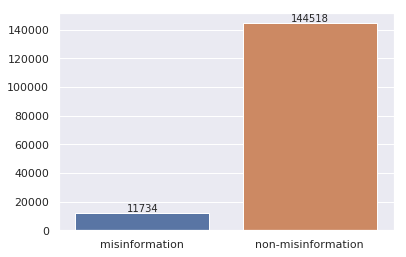

In [6]:
print('total data')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

data after remove duplicates


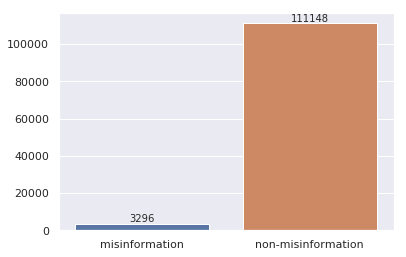

In [7]:
#removing duplicates
    
df = df.drop_duplicates(subset=['text'])    
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [8]:
print(len(texts))
print(len(y))

114444
114444


# Pre-processing
* convert url in just the domain
* separate emojis
* punctuation

[Some suggestions in this work](https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb)

* **Special character cleaning**

* **Upcase/downcase**

* **Punctuation signs** 

* **Possessive pronouns**

* **Stemming or Lemmatization**

* **Stop words**

In [9]:
#emojis and punctuation
emojis_list = list(emoji.UNICODE_EMOJI.keys())
punct = list(string.punctuation)
emojis_punct = emojis_list + punct

def processEmojisPunctuation(text, remove_punct = True):
    '''
    Put spaces between emojis. Removes punctuation.
    '''
    #get all unique chars
    chars = set(text)
    #for each unique char in text, do:
    for c in chars:
        #remove punctuation
        if remove_punct:
            if c in emojis_list:
                text = text.replace(c, ' ' + c + ' ')
            if c in punct:
                text = text.replace(c, ' ')
                
        #put spaces between punctuation
        else:
            if c in emojis_punct:
                text = text.replace(c, ' ' + c + ' ')          
            
    text = text.replace('  ', ' ')
    return text

#stop words removal
stop_words = list(stopwords.words('portuguese'))
new_stopwords = ['aí','pra','vão','vou','onde','lá','aqui',
                 'tá','pode','pois','so','deu','agora','todo',
                 'nao','ja','vc', 'bom', 'ai','kkk','kkkk','ta', 'voce', 'alguem', 'ne', 'pq',
                 'cara','to','mim','la','vcs','tbm', 'tudo']
stop_words = stop_words + new_stopwords
final_stop_words = []
for sw in stop_words:
    sw = ' '+ sw + ' '
    final_stop_words.append(sw)

def removeStopwords(text):
    for sw in final_stop_words:
        text = text.replace(sw,' ')
    text = text.replace('  ',' ')
    return text

#lemmatization
nlp = spacy.load('pt_core_news_sm')
def lemmatization(text):
    doc = nlp(text)
    for token in doc:
        if token.text != token.lemma_:
            text = text.replace(token.text, token.lemma_)
    return text
    

def domainUrl(text):
    '''
    Substitutes an URL in a text for the domain of this URL
    Input: an string
    Output: the string with the modified URL
    '''    
    if 'http' in text:
        re_url = '[^\s]*https*://[^\s]*'
        matches = re.findall(re_url, text, flags=re.IGNORECASE)
        for m in matches:
            domain = m.split('//')
            domain = domain[1].split('/')[0]
            text = re.sub(re_url, domain, text, 1)
        return text
    else:
        return text 

def preprocess(text):
    text = text.lower().strip()
    text = domainUrl(text)
    text = processEmojisPunctuation(text)
    text = removeStopwords(text)
    text = lemmatization(text)
    return text
           

In [10]:
#if experiment is with pre-processed text
if 'processed' in experiment:
        #text was already pre-processed
        if pre_processed:
            pro_texts = pickle.load(open( "data/2018/processed_texts.p", "rb" ))            
        else:
            pro_texts = [preprocess(t) for t in texts]
            pickle.dump(pro_texts, open( "data/2018/processed_texts.p", "wb" ))
else:
    pro_texts = [t for t in texts]

In [11]:
list(zip(pro_texts[0:10], texts[0:10]))

[('O Bolsonaro tem que estar preparado pra responder assim...',
  'O Bolsonaro tem que estar preparado pra responder assim...'),
 ('Boaaa', 'Boaaa'),
 ('👏🏻👏🏻👏🏻', '👏🏻👏🏻👏🏻'),
 ('Alguém tem o vídeo do CangaCiro falando da desenvoltura do Bolsonaro na Globonews, colocando aquela cambada de joelhos?',
  'Alguém tem o vídeo do CangaCiro falando da desenvoltura do Bolsonaro na Globonews, colocando aquela cambada de joelhos?'),
 ('https://exame.abril.com.br/brasil/bolsonaro-promete-abrir-arquivos-do-bndes-e-da-petrobras-se-eleito/',
  'https://exame.abril.com.br/brasil/bolsonaro-promete-abrir-arquivos-do-bndes-e-da-petrobras-se-eleito/'),
 ('No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.',
  'No dia 07 de Outubro, quando for votar, não esqueça do que os esquerdopatas pensam da classe média.'),
 ('A cara do Felipão quando viu a foto do Pablo Vittar no gatorade..',
  'A cara do Felipão quando viu a foto do Pablo Vittar no gatorade..'),
 ('😂😂😂😂

In [12]:
print(len(pro_texts))
print(len(y))

114444
114444


## Train-test split

In [13]:
#random state = 42 for reprudictibility
texts_train, texts_test, y_train, y_test = train_test_split(pro_texts, y, test_size=0.3, 
                                                                    stratify = y, random_state=42)

full_texts_train, full_texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.3, 
                                                                    stratify = y, random_state=42)

## Vectorization

In [14]:
max_feat = 500

if 'tfidf' in experiment:
    if 'max_features' in experiment:
        vectorizer = TfidfVectorizer(max_features = max_feat) 
    else:
        vectorizer = TfidfVectorizer()
        
elif 'bow' in experiment:
    if 'max_features' in experiment:
        vectorizer = CountVectorizer(max_features = max_feat, binary=True) 
    else:
        vectorizer = CountVectorizer(binary=True)

vectorizer.fit(texts_train)   
X_train = vectorizer.transform(texts_train)
X_test = vectorizer.transform(texts_test)
X = vectorizer.transform(pro_texts)

## SVD visualization

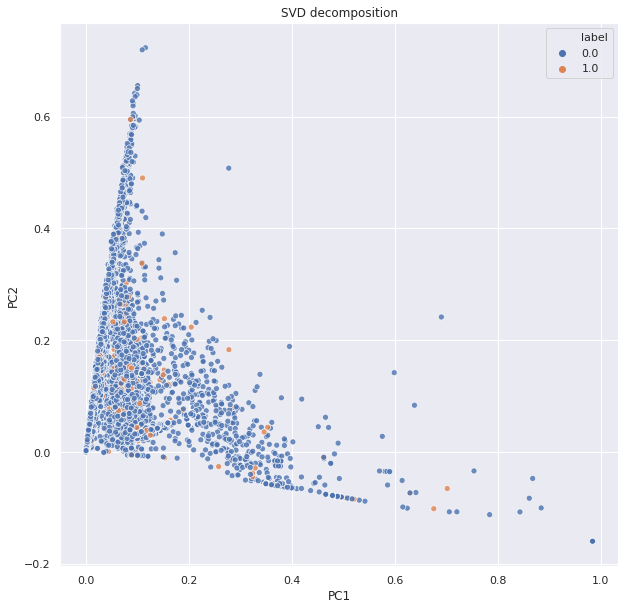

In [15]:
n_components = 2
title = "SVD decomposition"
# Creation of the model
mod = TruncatedSVD(n_components=n_components)
# Fit and transform the features
principal_components = mod.fit_transform(X)

# Put them into a dataframe
df_features = pd.DataFrame(data=principal_components,
                 columns=['PC1', 'PC2'])

df_features['label'] = y

# Plot
plt.figure(figsize=(10,10))
sns.scatterplot(x='PC1',
                y='PC2',
                hue="label", 
                data=df_features,
                alpha=.8).set_title(title);

## Data balancing

In [16]:
if 'smote' in experiment:
    #oversampling with SMOTE
    sm = SMOTE(random_state = 42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
elif 'undersampling' in experiment:
    rus = RandomUnderSampler(random_state = 42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
elif 'random_oversampling' in experiment:
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
X_train.shape

(155606, 69571)

In [17]:
vocab_size = X_train.shape[1]
vocab_size

69571

## Metrics

In [18]:
scenario = []
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

## Models training and test

Logistic Regression


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.99      0.95      0.97     33345
           1       0.32      0.76      0.45       989

    accuracy                           0.95     34334
   macro avg       0.66      0.85      0.71     34334
weighted avg       0.97      0.95      0.96     34334

AUC:  0.9438910183255881


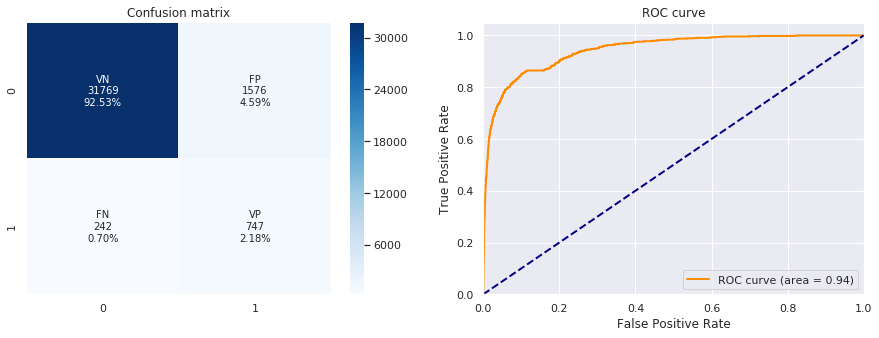

In [19]:
print('Logistic Regression')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     33345
           1       0.30      0.49      0.37       989

    accuracy                           0.95     34334
   macro avg       0.64      0.73      0.67     34334
weighted avg       0.96      0.95      0.96     34334

AUC:  0.9126504307920944


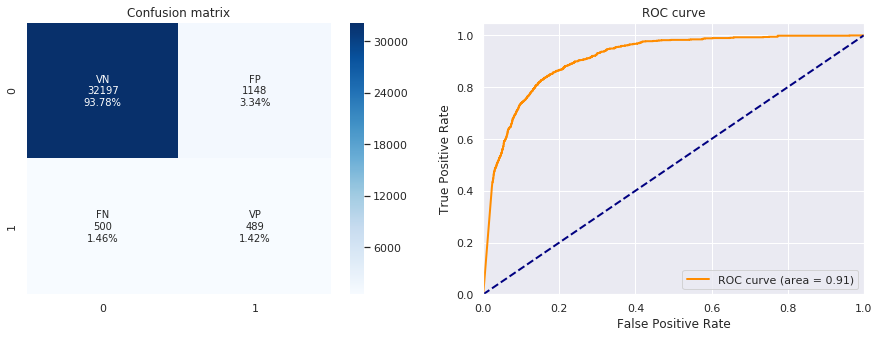

In [20]:
print('Bernoulli Naive-Bayes')
bnb = BernoulliNB().fit(X_train, y_train)
y_pred = bnb.predict(X_test)
y_prob = bnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('bernoulli naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multinomial Naive-Bayes
              precision    recall  f1-score   support

           0       0.99      0.77      0.87     33345
           1       0.10      0.84      0.17       989

    accuracy                           0.77     34334
   macro avg       0.54      0.80      0.52     34334
weighted avg       0.97      0.77      0.85     34334

AUC:  0.8881937782847792


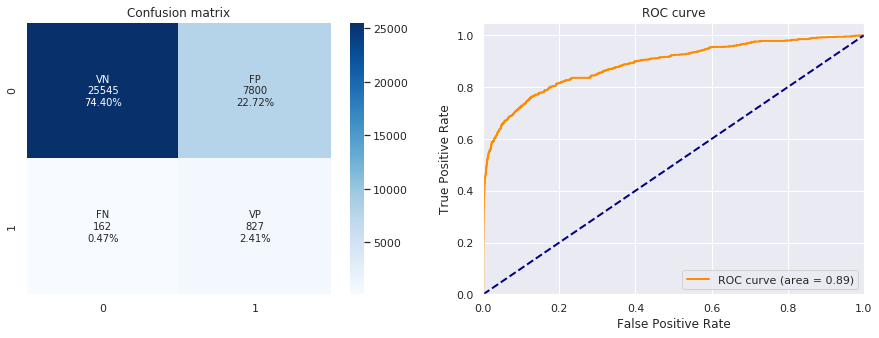

In [21]:
print('Multinomial Naive-Bayes')
mnb = MultinomialNB().fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_prob = mnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('multinomial naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Linear Support Vector Machine
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     33345
           1       0.47      0.65      0.54       989

    accuracy                           0.97     34334
   macro avg       0.73      0.81      0.76     34334
weighted avg       0.97      0.97      0.97     34334



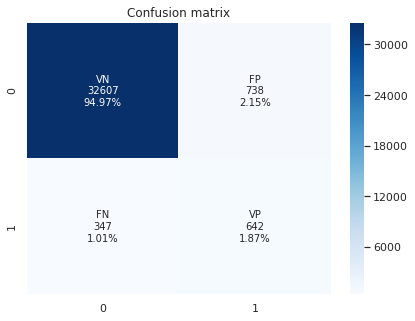

In [22]:
print('Linear Support Vector Machine')
svm = LinearSVC().fit(X_train, y_train)
y_pred = svm.predict(X_test)
#y_prob = svm.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred)

model.append('linear svm')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

KNN
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     33345
           1       0.25      0.58      0.35       989

    accuracy                           0.94     34334
   macro avg       0.62      0.77      0.66     34334
weighted avg       0.97      0.94      0.95     34334

AUC:  0.7665791846463444


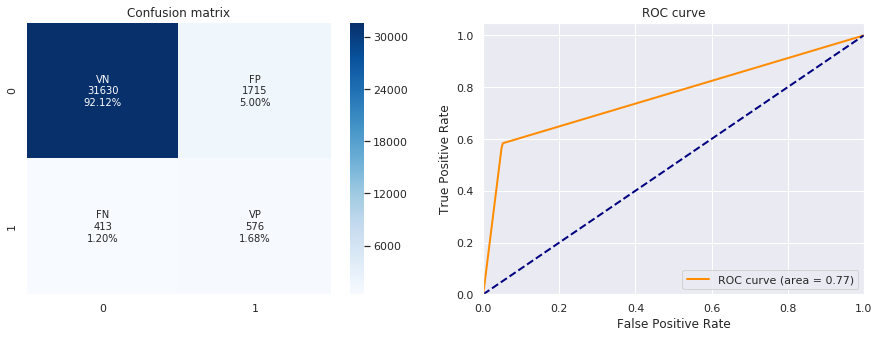

In [23]:
print('KNN')
rf = KNeighborsClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('knn')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     33345
           1       0.92      0.51      0.66       989

    accuracy                           0.98     34334
   macro avg       0.95      0.76      0.82     34334
weighted avg       0.98      0.98      0.98     34334

AUC:  0.9519629858568713


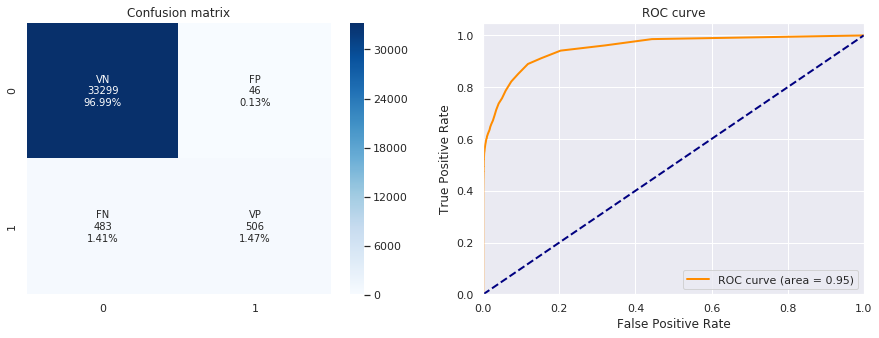

In [24]:
print('Random Forest')
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('random forest')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Gradient Boosting
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     33345
           1       0.16      0.81      0.27       989

    accuracy                           0.87     34334
   macro avg       0.58      0.84      0.60     34334
weighted avg       0.97      0.87      0.91     34334

AUC:  0.9240630440619798


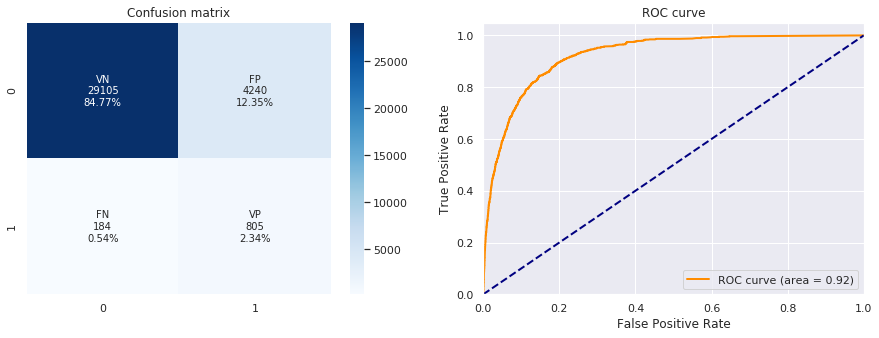

In [25]:
print('Gradient Boosting')
gb = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('gradient boosting')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multilayer perceptron
Iteration 1, loss = 0.15326948
Iteration 2, loss = 0.02724335
Iteration 3, loss = 0.01595870
Iteration 4, loss = 0.01143176
Iteration 5, loss = 0.00883413
Iteration 6, loss = 0.00743709
Iteration 7, loss = 0.00653268
Iteration 8, loss = 0.00593233
Iteration 9, loss = 0.00563547
Iteration 10, loss = 0.00536657


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33345
           1       0.59      0.58      0.59       989

    accuracy                           0.98     34334
   macro avg       0.79      0.78      0.79     34334
weighted avg       0.98      0.98      0.98     34334

AUC:  0.8976203374319494


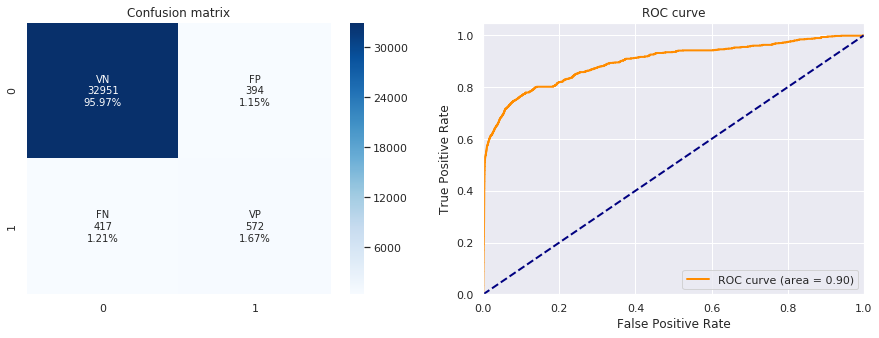

In [26]:
print('Multilayer perceptron')
mlp = MLPClassifier(max_iter=10,verbose=True).fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('mlp')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

## Results

In [27]:
end_time = time.time()
ellapsed_time = end_time - start_time
print('ellapsed time (min):', ellapsed_time/60)

ellapsed time (min): 69.06327946980794


In [28]:
df_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})

df_metrics['vocab'] = [vocab_size]*len(df_metrics)
df_metrics

,model,accuracy,precision,recall,f1 score,auc score,vocab
0,logistic regression,0.947050,0.321567,0.755308,0.451087,0.943891,69571
1,bernoulli naive-bayes,0.952001,0.298717,0.494439,0.372430,0.912650,69571
2,multinomial naive-bayes,0.768102,0.095862,0.836198,0.172005,0.888194,69571
3,linear svm,0.968399,0.465217,0.649141,0.542001,0.000000,69571
4,knn,0.938021,0.251419,0.582406,0.351220,0.766579,69571
5,random forest,0.984593,0.916667,0.511628,0.656716,0.951963,69571
6,gradient boosting,0.871148,0.159564,0.813953,0.266821,0.924063,69571
7,mlp,0.976379,0.592133,0.578362,0.585166,0.897620,69571


In [29]:
file = 'results/2018/ml/' + experiment + '.csv'
df_metrics.to_csv(file, index = False)
file

'results/2018/ml/ml-tfidf-random_oversampling.csv'

# Error examples with random forest

In [30]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_pred = mlp.predict(X_test)
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('Total test data:', len(y_pred))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

Total test data: 34334
False negative:  417
False positive:  394


In [31]:
texts_FN = [texts_test[fn] for fn in FN]
texts_FP = [texts_test[fp] for fp in FP]

### False negative

In [32]:
for fn in texts_FN:
    print('***')
    print(fn)
    print('***')

***
Toda essa historinha, segundo fonte ouvida no gabinete de um deputado PTista, poderia ser mera ficção se a quadrilha não divulgasse um vídeo, que pode ser o início desta armação. http://ricardochudo.blogspot.com/2018/10/seriam-tao-ousados.html
***
***
Ouçam e espalhem esse áudio, com explicações dos motivos de não ter greve de caminhoneiro.👇👇
***
***
*Saberemos o resultado REAL das eleições no dia 11/10/18. Missão operação antifraude 2018 direto dos EUA, pede que REPASSEM ao maior número de brasileiros. Assistam o vídeo*. 🇧🇷🔽
***
***
Ciro Gomes se entrega e entrega Lula
Ao vivo.
Agora quero ver o povo falar que é Fake.
Acorda Brasil
***
***
Bom dia nação que apoia o Bolsonaro, vamos continuar no deslike no vídeo do Marco Antônio Villa que decidiu chamar o Bolsonaro de covarde por ele não querer dar ibope a Jovem Pan. Vamos mostrar a esse comunista fabiano o nosso apoio ao Mito.
Brasil acima de tudo 🇧🇷

https://youtu.be/uZs-xwhWrwU
***
***
Áudio da atriz Susana Vieira no grupo dos a

### False positives

In [33]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
URGENTE !!!!! VAMOS COMPARTILHAR !!!!! A VERDADE VAI CHEGAR... PRECISA CHEGAR!!!!!

Os advogados disseram que foram contratados por um fiel da igreja Testemunhas de Jeová de Montes Claros, frequentada pela família de Adélio.
 Em comunicado à imprensa, a igreja Testemunhas de Jeová no Brasil disse que não contratou os advogados e que nem Adélio nem sua família são seguidores da igreja. "Portanto, a declaração do advogado de que foi contratado por Testemunha de Jeová, conforme veiculada pela mídia, não é verídica".

QUEM ESTA PAGANDO ESSES ADVOGADOS?!
 
O advogado Zanone Manuel de Oliveira Júnior, que nas redes sociais é um animado ativista pró-Lula, segundo matéria divulgada pelo jornal Estado de Minas, utilizou um avião particular para deixar Belo Horizonte às pressas rumo a Juiz de Fora!

Isso é muito serio, é um atentado !!!!
***


***
Gente...entrem lá...ela tá levando uma surra de deslike 🤣
***


***
URGENTE: Reportagem da Fox News denuncia interferência do Irã nas eleições br

# Hyperparameter tunning

In [34]:
#validation set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify = y_train)